In [2]:
import sys
print(sys.version)

3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


# Introduction
This document outlines techniques to preprocess text and represent it using word embedding techniques to facilitate detecting similarity between chunks of text. 

The motivation for this is to power intelligent inventory search in e-commerce and dataset will be specific to e-commerce. 

## Preprocessing
The preprocessing of text is required to ensure cleanliness and correct format of data. Commonly followed steps include:
* Uniform case - ensuring uniformity case of text. This step could result in loss of information such as noun capitalization
* Remove stop words - stop words such as 'is', 'the', 'are', 'a', 'an' etc are removed
* Remove punctuation - punctuations such as '.', '!', '?', '$' etc are removed. Note: this could lead to further loss of information from the text
* lemmatization - process of producing morphological variants of a base word or lemma e.g. democracy, democratic, democratization
* Stemming - heuristic method of removing affixes e.g. drawing -> draw, drawings -> draw


## Word Embeddings
Word embeddings are a way to represent the words within a chunk of text(Document) so as to capture as much of the semantic (vocabulary and meaning) and syntax (grammatical structure). Techniques include:
* Bag of Words(BoW)
* TF-IDF
* Word2Vec
    * Continous BoW
    * Continous Skip-gram
    
### Sentence, phrase, paragraph embeddings
Once we have calculated the individual word embeddings, we can use these embeddings to determine embeddings for sentences or a group of text. Techniques include:
* Unweighted word mean
* Smooth Inverse Frequency (SIF)
    
## Similarity
Once representations/vectors of text is calculated, we will be using simalrity functions to determine similarity
* Cosine similarity
* Jaccard distance
* Euclidean distance
* Word Mover's distance
    
## Methodology
General methodology in NLP include the following, however techniques applied within each step may vary.
* Text Preprocessing
* Feature Extraction
* Similarity Calculation
* Threshold/Decision Function

## Dataset
We'll be using a text similarity dataset from [Kaggle](https://www.kaggle.com/rishisankineni/text-similarity?select=train.csv). Download the dataset (`train.csv` and `test.csv`) to a directory named `data`. Once you have a satisfactory model, test your model on an e-commerce [Kaggle](https://www.kaggle.com/cclark/product-item-data) dataset. Download the data to the `data` directory and rename file to `ecommerce_product_listing.csv`. You may need to update your methodology for the new dataset.

## Libraries
We will be using existing libraries and all input dataset will be processed as per the English language semantics and syntax
### `nltk`
Install all supporting libraries for the `nltk` module using the provided script. 
`python -m nltk.downloader all`
### [`gensim`](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py)

In [24]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import pandas as pd
import nltk

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import  WordNetLemmatizer
from unidecode import unidecode
import string

## Preprocesing

In [4]:
# list of stop words and punctuation in the English language
STOP_WORDS = stopwords.words('english') + list(string.punctuation)
lemmatizer = WordNetLemmatizer()

def pre_process(corpus):
    '''pre processes corpus(input text) before processing'''
    # uniform case
    corpus = corpus.lower()
    # transate non ascii characters to ascii
    corpus = unidecode(corpus)
    # tokenize words
    corpus = word_tokenize(corpus)
    # remove stop words
    corpus = [i for i in corpus if i not in STOP_WORDS]
    # lemmatize
    for index, word in enumerate(corpus):
        corpus[index] = lemmatizer.lemmatize(word)
    
        
    return " ".join(corpus)
    


In [5]:
pre_process('Hi, my name is José. I live in Puñta Caña. I ate couple of eggs and went swimming yesterday')

'hi name jose live punta cana ate couple egg went swimming yesterday'

## Feature Extraction

### TF-IDF
Term Frequency is the `count` of word `t` in document `d` hence `tf(t,d)`

Inverse Document Frequency  determines how rare or common a word is across all documents `D`, represented on a log scale. `idf(t,D) = log(N/dfq)` where `N` = Total number of documents, `dfq` is number of documents in which the word `t` appears.

Hence `TF-IDF(t,d,D) = tf(t,d).idf(t,D)`. 

In [21]:
# use sklearn's implementation of TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    'summer dress ideal for picnics, long walks in the park or a BBQ', 
    'semi-casual attire, perfect for both work and a night out with friends'
]
for index, text in enumerate(corpus):
    corpus[index] = pre_process(text)
    
# create vocabulary using uni, bi and tri grams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
# fit and transform TF-IDF
tfidf_vectorizer.fit(corpus)
feature_vectors = tfidf_vectorizer.transform(corpus)
sample_count, feature_count = feature_vectors.shape
print(f'number of samples={sample_count}, number of features={feature_count}')

number of samples=2, number of features=39


### Principle Component Analysis (PCA)
PCA is used to reduce dimensionality of a vector space which is useful in speeding the learning process and also in visualizing the vector space. 

Goal of PCA is to explain variance in the dataset with key components(dimensions). Recommended explainability of PCA should be at least `85%` or higher else the reduction in dimension has lost too much information and you should consider increasing the number of dimesions

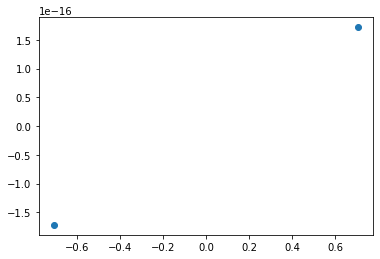

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

X = feature_vectors.todense()
pca = PCA(n_components=2).fit(X)
data_2D = pca.transform(X)

plt.scatter(data_2D[:,0], data_2D[:,1])

In [19]:
{f'pca explainability={pca.explained_variance_ratio_}'}

{'pca explainability=[1.00000000e+00 1.38044059e-32]'}

### Word2Vec

Word2Vec embeddings represent words as multidimensional arrays. Two unsupervised algorithms are commonly used to generate these embeddings:
* Continous Bag of Words (CBoW)
* Skip-gram 

They are similar approaches that use different techniques.

#### CBoW vs Skip-gram

CBoW attempts to predict the most likey word by looking at the words around it. Skip-gram uses the reverse approach of trying to predict the most likely words around a given word as depicted in the diagram below.

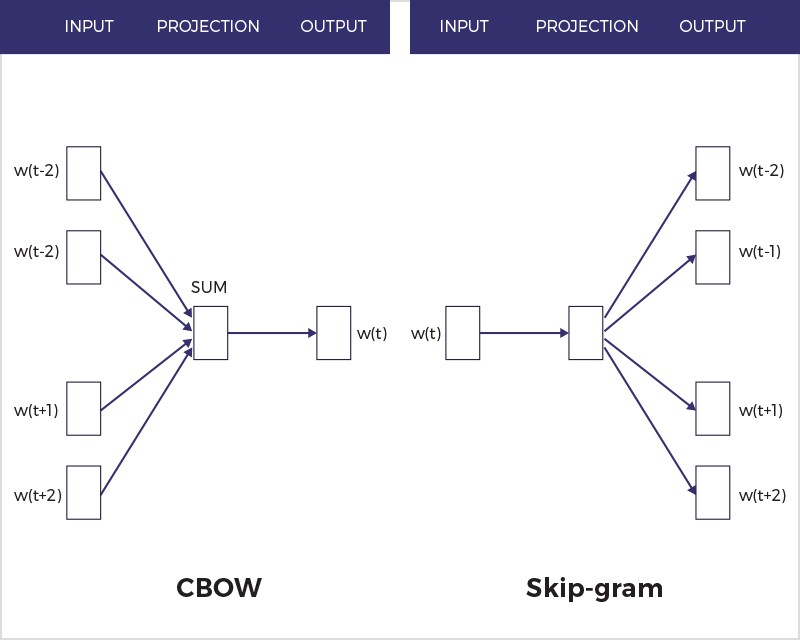

We won't be training models to generate the vector space as this requires a massive text corpus, e.g. entire Wikipedia text corpus and is both compute and time intensive. There are pretrained models we can leverage to map input words to multi-dimensional vector space. 

`gensim` offers one such model trained on a corpus of over 100 Billion words. The model represents each word in a 300 dimension vector space. 


##### Shortcomings
Word2Vec suffers from inability to capture contextual information for each word. 

> “The man was accused of robbing a bank.” “The man went fishing by the bank of the river.”

Word2Vec would represnt `bank` as the same word embedding for the two examples.

There are different techniques to better capture the semantics of *word sequences* i.e. phrases, sentences and paragraphs. These techniques range from simple additional composition of the individual word embeddings and SIP to complex CNNs and RNNs.

##### SIF

Simple Inverse Frequency is a simple technique that offers significant performance boost as compared to unweighted average on a variety of textual similarity tasks. SIP calculates the weighted average of word vectors in a sentence and then removes the projection of the averages on their first singular vector. This means rather than taking mean of word embedding which gives equal weight to each word in a sentence irrespective of semantic similarity, every word embedding is weighted by `a/(a + p(w))` where `a` is smoothing parameter that needs to be tinkered (around `0.001`) and `p(w)` is the estimated frequency of word in corpus. 

##### BERT

`BERT`(Bidirectional Encoder Representation from Transfomers) from Google takes into account the context around a word to better represnt each word. For example:

BERT produces context-informed word embeddings which would represent `bank` in the two contexts differently. 



### Gensim

In [8]:
# download pretrained model on google news set

import gensim.downloader as api

# import gensim Word2Vec model - if loading existing model
from gensim.models import Word2Vec
import numpy as np

# use 
goolge_news_wv_model = api.load('word2vec-google-news-300')

# Load pre-trained model if you have one
# model = Word2Vec.load('word2vec.bin')

2020-07-24 09:26:37,822 : INFO : loading projection weights from /Users/sunshah/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
2020-07-24 09:29:17,239 : INFO : loaded (3000000, 300) matrix from /Users/sunshah/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


### Explore word embeddings for model

In [10]:
google_news_wv_model = api.load('word2vec-google-news-300')

2020-07-24 09:32:51,502 : INFO : loading projection weights from /Users/sunshah/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
2020-07-24 09:35:19,517 : INFO : loaded (3000000, 300) matrix from /Users/sunshah/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [11]:
google_news_wv_modele_news_wv_model

In [12]:
# print out a few words in the model's vocab
for index, word in enumerate(google_news_wv_model.vocab):
    if index == 10:
        break
    print(word)

</s>
in
for
that
is
on
##
The
with
said


In [13]:
# view embeddings of a few words
words = ['Shorts', 'news', 'United', 'bank', 'theater']
for word in words:
    try:
        print(f'"{word}" has embedding of {google_news_wv_model[word]}')
    except KeyError:
        print(f'{word} not found found in model')
    

"Shorts" has embedding of [-0.59765625 -0.09667969 -0.07763672  0.26171875  0.13964844 -0.34960938
 -0.09277344  0.17675781 -0.05224609 -0.04541016  0.16601562  0.29882812
 -0.10449219  0.13574219 -0.02685547 -0.10058594  0.00579834 -0.22851562
  0.07373047 -0.01623535 -0.09277344 -0.04541016  0.22851562  0.2421875
  0.35546875  0.00592041 -0.16894531  0.20898438  0.47851562 -0.01239014
 -0.05322266  0.15722656  0.03417969 -0.0534668   0.07519531 -0.25390625
  0.01696777 -0.04467773 -0.42578125  0.10791016  0.02270508  0.23828125
 -0.13183594 -0.00512695 -0.21191406 -0.07617188  0.01208496 -0.11181641
  0.25585938  0.11376953 -0.07714844 -0.25390625  0.05712891  0.33203125
  0.09423828 -0.25        0.17480469  0.15917969 -0.44921875 -0.08740234
 -0.08251953  0.171875   -0.02453613  0.06347656 -0.22070312 -0.24902344
 -0.10009766  0.265625    0.46875     0.3203125   0.02636719 -0.01086426
 -0.13671875  0.16113281 -0.08251953  0.0559082   0.11425781 -0.14648438
 -0.06079102  0.25390625  

In [22]:
# explore similarity between wrods
products = [
    ('shirt', 'sweater'),
    ('shirt', 'vest'),
    ('shirt', 'coat'),
    ('shirt', 'blazer'),
    ('shirt', 'pant'),
    ('shirt', 'watch'), 
    ('shirt', 'earrings'),
    ('shirt', 'dress'),
    ('shirt', 'shoes'),
    ('shirt', 'kettle'),
    ('shirt', 'chips'),
    ('shirt', 'polo')
]

for product1, product2 in products:
    print(f'similarity {product1}, {product2} = {google_news_wv_model.similarity(product1, product2)}')

similarity shirt, sweater = 0.6363667249679565
similarity shirt, vest = 0.40609830617904663
similarity shirt, coat = 0.4648246765136719
similarity shirt, blazer = 0.6206684112548828
similarity shirt, pant = 0.398124635219574
similarity shirt, watch = 0.11595369875431061
similarity shirt, earrings = 0.329196035861969
similarity shirt, dress = 0.46070489287376404
similarity shirt, shoes = 0.4370700418949127
similarity shirt, kettle = 0.2555835545063019
similarity shirt, chips = 0.11398275196552277
similarity shirt, polo = 0.2137981355190277


In [23]:
# print out top words similar
print(google_news_wv_model.most_similar(['shirt'], topn=7))

[('shirts', 0.7683461904525757), ('T_shirt', 0.7317519187927246), ('t_shirt', 0.7023723125457764), ('sweatshirt', 0.700203001499176), ('polo_shirt', 0.6802045106887817), ('jacket', 0.6619144082069397), ('jersey', 0.6591905355453491)]


## Vector Similarity 

There are a few statistical methods of calculating similarity between two vectors
* Cosine
* Word Mover's distance
* Euclidean distance

### Cosine 
This is the dot product between two vector respresentations which calculates the angle between them.
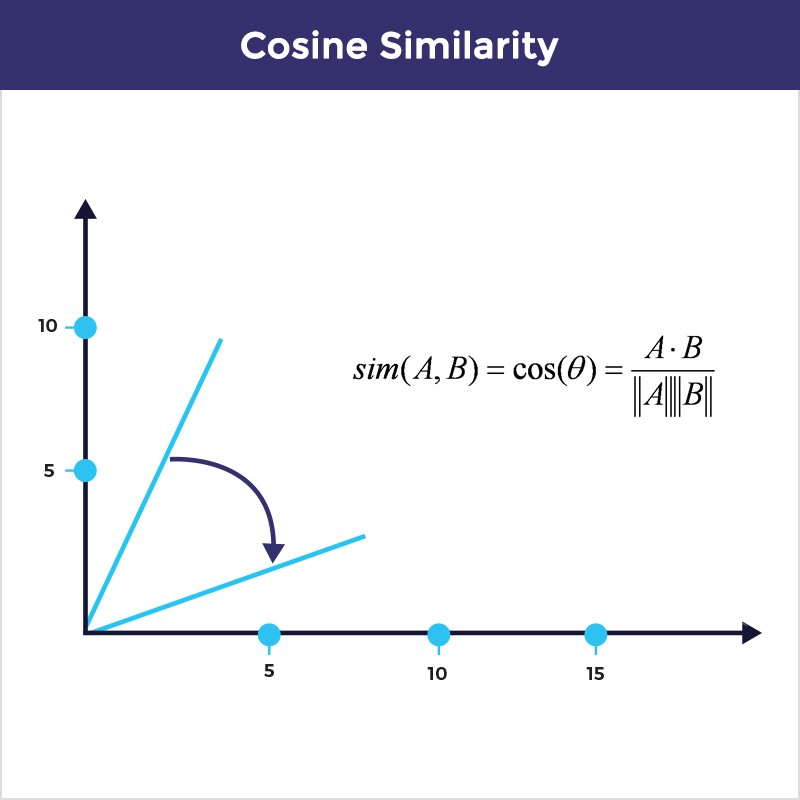

### Word Mover's distance
This measures the minimum "distance" needed to travel from one embedding to the next which captures the semantic space needed to be traveled. 
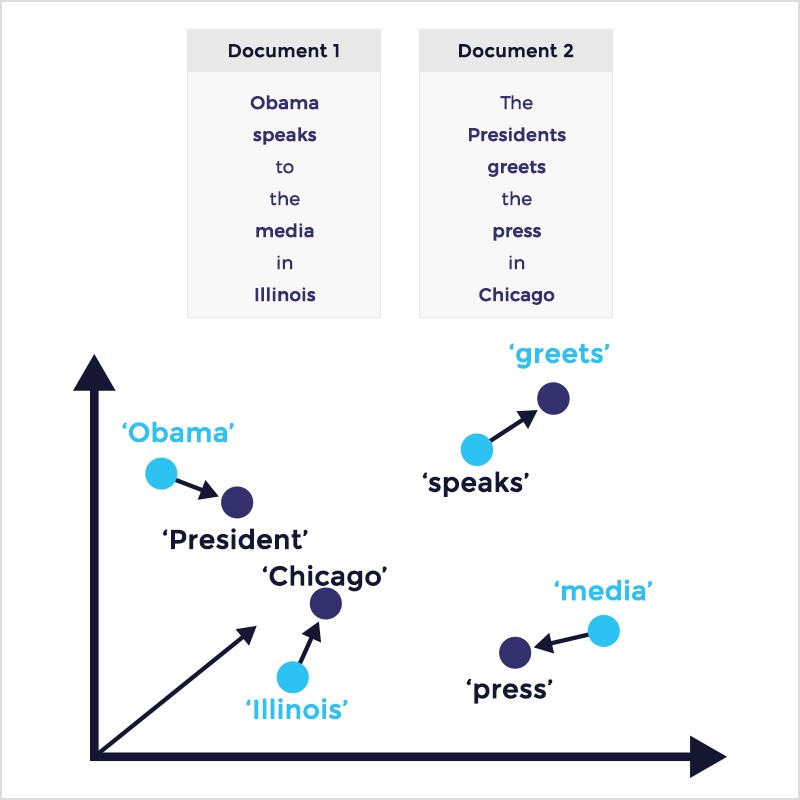

### Euclidean Distance
This is the distance between two points in a vector space as the crow flies. The visualization below depicts this in a 2D space. 
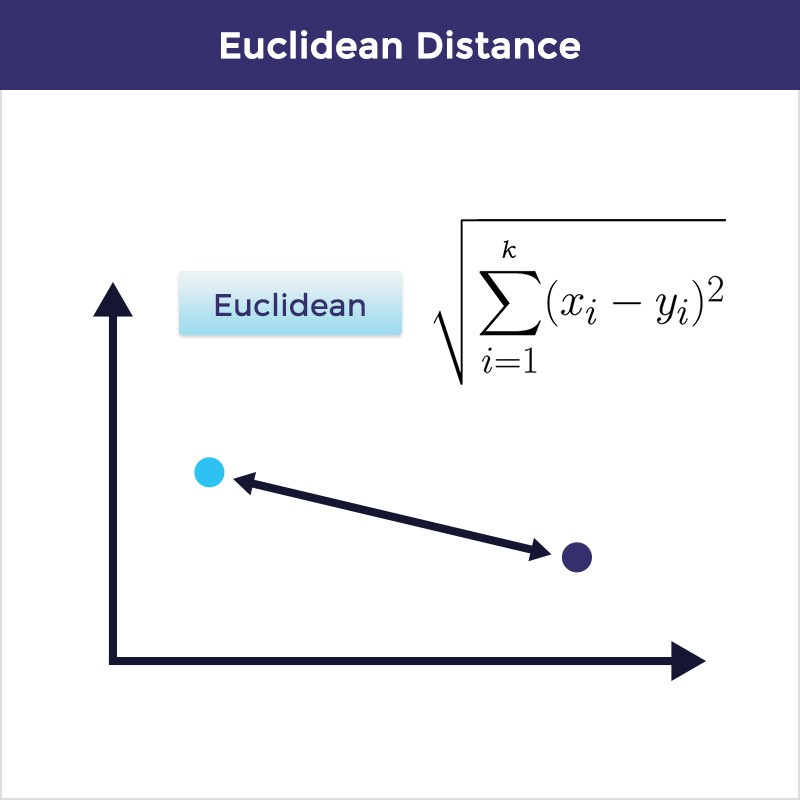